In [1]:
import time
import os, zipfile, requests, pandas as pd, geopandas as gpd, osmnx as ox, networkx as nx
import ast
import statistics
import numpy as np
from sklearn.neighbors import BallTree

ox.config(use_cache=True, log_console=True)
print('ox {}\nnx {}'.format(ox.__version__, nx.__version__))
start_time = time.time()

ox 0.8.2
nx 2.1


In [2]:
# point to the shapefile for counties
counties_shapefile_url = 'http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_500k.zip'

# identify bay area counties by fips code
bayarea = {'Alameda':'001',
           'Contra Costa':'013',
           'Marin':'041',
           'Napa':'055',
           'San Francisco':'075',
           'San Mateo':'081',
           'Santa Clara':'085',
           'Solano':'095',
           'Sonoma':'097'
          }

# Generate the nodes and edges for the specified network (based on metropolitan area counties and the subsequent polygon created in osmnx

In [3]:
counties_shapefile_dir = 'cb_2016_us_county_500k'
counties = gpd.read_file("{}.shp".format(counties_shapefile_dir))
len(counties)

3233

In [4]:
# retain only those tracts that are in the bay area counties
mask = (counties['STATEFP'] == '06') & (counties['COUNTYFP'].isin(bayarea.values()))
gdf_bay = counties[mask]
len(gdf_bay)

9

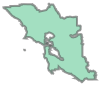

In [5]:
bayarea_polygon = gdf_bay.unary_union
bayarea_polygon

In [6]:
# get the convex hull, otherwise we'll cut out bridges over the bay
bayarea_polygon_hull = bayarea_polygon.convex_hull
bayarea_polygon_hull_proj, crs = ox.project_geometry(bayarea_polygon_hull)

In [7]:
# project by a mile to get connectivities surrounding our O-Ds
bayarea_polygon_hull_proj_buff = bayarea_polygon_hull_proj.buffer(1600) #1 mile in meters
bayarea_polygon_hull_buff, crs = ox.project_geometry(bayarea_polygon_hull_proj_buff, crs=crs, to_latlong=True)

In [8]:
# do not simplify yet, we'll strip out unwanted local streets before simplification
G = ox.graph_from_polygon(bayarea_polygon_hull_buff, network_type='drive', simplify=False)


In [9]:
print(len(G.nodes()))
print(len(G.edges()))
#for i, edge in enumerate(G.edges(keys=True, data=True)):
#    if i < 100:
#        print(edge[3]['highway'])

1245586
2379094


In [10]:
G2 = G.copy()

In [11]:
# identify all the edge types we want to retain
types = ['motorway', 'motorway_link', 'trunk', 'trunk_link', 
         'primary', 'primary_link', 'secondary', 'secondary_link',
         'tertiary', 'tertiary_link', 'unclassified', 'road']
         #'residential', 'living_street']


#types = ['motorway', 'motorway_link', 
#         'primary', 'primary_link', 'secondary', 'secondary_link',
#         'tertiary', 'tertiary_link']

minor_streets = [(u, v, k) for u, v, k, d in G2.edges(keys=True, data=True) if d['highway'] not in types]

In [12]:
G2.remove_edges_from(minor_streets)
G2 = ox.remove_isolated_nodes(G2)
G2_connected = ox.get_largest_component(G2, strongly=True)
G2_simp = ox.simplify_graph(G2_connected, strict=True)

In [13]:
print(len(G2_simp.nodes()))
print(len(G2_simp.edges()))

31121
66082


In [14]:
# create a unique ID for each edge because osmid can hold multiple values due to topology simplification
i = 0
for u, v, k, d in G2_simp.edges(data=True, keys=True):
    d['uniqueid'] = i
    i += 1

In [15]:
print(len(G2_simp.nodes()))
print(len(G2_simp.edges()))

31121
66082


In [16]:
# save nodes and edges list as csv
nodes, edges = ox.graph_to_gdfs(G2_simp, node_geometry=False, fill_edge_geometry=False)

ecols = ['uniqueid', 'u', 'v', 'key', 'oneway', 'highway', 'name', 'length',
         'lanes', 'width', 'est_width', 'maxspeed', 'access', 'service',
         'bridge', 'tunnel', 'area', 'junction', 'osmid', 'ref']

#ecols = ['uniqueid', 'u', 'v', 'key', 'length', 'lanes', 'maxspeed']

edges = edges.drop(columns=['geometry']).reindex(columns=ecols)
nodes = nodes.reindex(columns=['osmid', 'x', 'y', 'ref', 'highway'])
#edges.rename(columns={'maxspeed':'speed_mph'}, inplace=True)

In [17]:
edges.head()

,uniqueid,u,v,key,oneway,highway,name,length,lanes,width,est_width,maxspeed,access,service,bridge,tunnel,area,junction,osmid,ref
0,0,309330024,253297204,0,True,motorway,Bayshore Freeway,320.849,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256787725,US 101
1,1,247385811,3401339837,0,True,primary,Wolfe Road,304.901,"[3, 4]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[158248728, 393494148]",NaN
2,2,247385811,65553953,0,False,secondary,East Homestead Road,363.613,5,NaN,NaN,35 mph,NaN,NaN,NaN,NaN,NaN,NaN,"[415833672, 506531251, 415833636, 415833670]",NaN
3,3,247385811,65580841,0,False,secondary,South Wolfe Road,409.556,"[5, 4, 6]",NaN,NaN,35 mph,NaN,NaN,NaN,NaN,NaN,NaN,"[415833689, 227833009, 415833677, 415833695]",NaN
4,4,247385811,4148256398,0,False,secondary,East Homestead Road,748.773,NaN,NaN,NaN,35 mph,NaN,NaN,NaN,NaN,NaN,NaN,"[417044260, 417044292, 544299499, 544299500, 4...",NaN


# Save the nodes as nodes.csv

In [18]:
nodes.to_csv('nodes.csv', index=False, encoding='utf-8')
#edges.to_csv('edges.csv', index=False, encoding='utf-8')

In [25]:
# save as graphml for re-using later
ox.save_graphml(G2_simp, filename='new_tertiary_simplified.graphml')

In [26]:
# save as shapefile for GIS
ox.save_graph_shapefile(G2_simp, filename='new_tertiary_simplified')

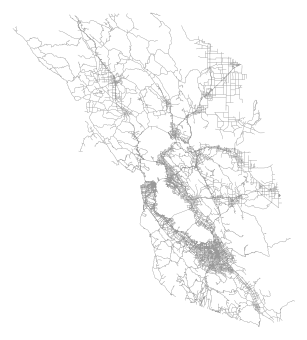

In [86]:
# visualize the network
fig, ax = ox.plot_graph(G2_simp, node_size=0, edge_linewidth=0.2)

# Generate speed, capacity, and volumes on the edges based on static data from OSM

In [19]:
# define speed defaults for each hwy type and number of lanes, so we can infer when lacking data
speed_defaults = {'tertiary' : {1 : 20, 2 : 20, 3 : 20, 4 : 20, -1 : 20},
                  'tertiary_link' : {1 : 20, 2 : 20, 3 : 20, 4 : 20, -1 : 20},
                  'secondary' : {1 : 25, 2 : 25, 3 : 25, 4 : 25, -1 : 25},
                  'secondary_link' : {1 : 25, 2 : 25, 3 : 25, 4 : 25, -1 : 25},
                  'primary' : {1 : 30, 2 : 30, 3 : 30, 4 : 30, -1 : 30},
                  'primary_link' : {1 : 30, 2 : 30, 3 : 30, 4 : 30, -1 : 30},
                  'trunk' : {1 : 45, 2 : 45, 3 : 45, 4 : 45, -1 : 45},
                  'trunk_link' : {1 : 45, 2 : 45, 3 : 45, 4 : 45, -1 : 45},
                  'motorway' : {1 : 50, 2 : 50, 3 : 65, 4 : 65, -1 : 57.5},
                  'motorway_link' : {1 : 50, 2 : 50, 3 : 65, 4 : 65, -1 : 57.5},
                  'unclassified' : {1 : 20, 2 : 20, 3 : 20, 4 : 20, -1 : 20},
                  'road' : {1 : 30, 2 : 30, 3 : 30, 4 : 30, -1 : 30}}

# define per-lane capacity defaults for each hwy type and number of lanes, so we can infer when lacking data
capacity_defaults = {'tertiary' : {1 : 900, 2 : 900, 3 : 900, 4 : 900, -1 : 900},
                     'tertiary_link' : {1 : 900, 2 : 900, 3 : 900, 4 : 900, -1 : 900},
                     'secondary' : {1 : 900, 2 : 900, 3 : 900, 4 : 900, -1 : 900},
                     'secondary_link' : {1 : 900, 2 : 900, 3 : 900, 4 : 900, -1 : 900},
                     'primary' : {1 : 1000, 2 : 1000, 3 : 1000, 4 : 1000, -1 : 1000},
                     'primary_link' : {1 : 1000, 2 : 1000, 3 : 1000, 4 : 1000, -1 : 1000},
                     'trunk' : {1 : 1900, 2 : 2000, 3 : 2000, 4 : 2000, -1 : 1975},
                     'trunk_link' : {1 : 1900, 2 : 2000, 3 : 2000, 4 : 2000, -1 : 1975},
                     'motorway' : {1 : 1900, 2 : 2000, 3 : 2000, 4 : 2200, -1 : 2025},
                     'motorway_link' : {1 : 1900, 2 : 2000, 3 : 2000, 4 : 2200, -1 : 2025},
                     'unclassified' : {1 : 800, 2 : 800, 3 : 800, 4 : 800, -1 : 800},
                     'road' : {1 : 900, 2 : 900, 3 : 900, 4 : 900, -1 : 900}}

# note: -1 is the key for the null value
# note: highway_links are given the same values as their highway types
# note: 'road' is effectively an OSM null highway type
# note: 'unclassified' is a highway type one step below tertiary in the OSM hierarchy

In [20]:
input_graphml_file = 'new_tertiary_simplified.graphml'

In [21]:
G = ox.load_graphml(input_graphml_file)
print(len(G))

31121


In [22]:
edges = ox.graph_to_gdfs(G, nodes=False, fill_edge_geometry=False)

# retain only useful columns
useful_cols = ['uniqueid', 'u', 'v', 'length', 'maxspeed', 'lanes', 'highway', 'oneway']
edges = edges[useful_cols]
edges.head()

,uniqueid,u,v,length,maxspeed,lanes,highway,oneway
0,0,309330024,253297204,320.849,NaN,5,motorway,True
1,1,247385811,3401339837,304.901,NaN,"[3, 4]",primary,True
2,2,247385811,65553953,363.613,35 mph,5,secondary,False
3,3,247385811,65580841,409.556,35 mph,"[5, 4, 6]",secondary,False
4,4,247385811,4148256398,748.773,35 mph,NaN,secondary,False


# Process highway type values #

In [23]:
# convert string representations of lists to lists
def convert_lists(value):
    if isinstance(value, str) and value.startswith('[') and value.endswith(']'):
        return ast.literal_eval(value) #parse str -> list
    else:
        return value
    
# convert string representation of multiple highway types to a list
edges['highway'] = edges['highway'].map(convert_lists)


In [24]:
# collapse multiple highway type values into a single value
def collapse_multiple_hwy_values(hwy):
    if isinstance(hwy, list):
        # if we find an item in our defaults dict, use that value
        # otherwise, just use the zeroth item in the list
        for item in hwy:
            if item in speed_defaults.keys():
                return item
        return hwy[0]
    else:
        return hwy

edges['highway'] = edges['highway'].map(collapse_multiple_hwy_values)
edges['highway'].value_counts().sort_index()

motorway           2621
motorway_link      4813
primary            8779
primary_link       1169
road                210
secondary         17589
secondary_link     1115
tertiary          19162
tertiary_link       474
trunk              1946
trunk_link          891
unclassified       7313
Name: highway, dtype: int64

# Process number of lanes values

In [25]:
# convert string representation of multiple lane values to a list
edges['lanes'] = edges['lanes'].map(convert_lists)

In [26]:
# collapse multiple lane values into a single value
def collapse_multiple_lane_values(value):
    if isinstance(value, list):
        #remove the elements with semicolons
        #numeric_values = [x for x in value if ';' not in x]
        # return the mean of the values in the list
        numeric_values = [int(x) for x in value]
        return int(statistics.mean(numeric_values))
    else:
        return value
    
#for x in range(len(edges['lanes'])):
#    print(edges['lanes'][x])


#for x in range(len(edges['lanes'])):
    #print(edges['lanes'][x])
    #if ';' in str(edges['lanes'][x]):
        #print(x)
        #print(edges['lanes'][x])
    #pd.Index(edges['lanes']).get_loc(['3; 4'])

edges['lanes'] = edges['lanes'].map(collapse_multiple_lane_values)

In [27]:
# remove hyphens in values like "1-2"
def remove_hyphens(x):
    val = x
    if isinstance(x, str):
        if '-' in x:
            val = x.split('-')[0]
    return val

def remove_semicolons(x):
    val = x
    if isinstance(x, str):
        if ';' in x:
            val = x.split(';')[0]
    return val
    

edges['lanes'] = edges['lanes'].map(remove_hyphens)
edges['lanes'] = edges['lanes'].map(remove_semicolons)

#for x in range(len(edges['lanes'])):
#    print(edges['lanes'][x])
#edges['lanes']

In [28]:
# calculate "typical" number of lanes per hwy type

#for x in range(len(edges['lanes'])):
#   print(edges['lanes'][x])
edges['lanes'] = edges['lanes'].astype(float)
lane_defaults = edges.groupby('highway')['lanes'].median()
lane_defaults = lane_defaults.fillna(value=2).to_dict() #'road' type is null
lane_defaults

{'motorway': 4.0,
 'motorway_link': 1.0,
 'primary': 3.0,
 'primary_link': 1.0,
 'road': 1.0,
 'secondary': 3.0,
 'secondary_link': 1.0,
 'tertiary': 2.0,
 'tertiary_link': 1.0,
 'trunk': 3.0,
 'trunk_link': 1.0,
 'unclassified': 2.0}

In [29]:
# impute number of lanes when data is missing
def impute_lanes(row):
    if pd.notnull(row['lanes']):
        return row['lanes']
    else:
        return lane_defaults[row['highway']]

edges['lanes'] = edges.apply(impute_lanes, axis=1).astype(int)

In [30]:
edges['lanes'].value_counts().sort_index()

1      8251
2     31818
3     19223
4      4607
5      1817
6       293
7        60
8        12
11        1
Name: lanes, dtype: int64

In [31]:
# if this is a two-way street, there will be two edges, one uv and one vu
# give each half the lanes
# probably not right... review https://wiki.openstreetmap.org/wiki/Key:lanes#Assumptions
def allocate_lanes(row):
    if row['oneway']:
        return row['lanes']
    else:
        return int(row['lanes'] / 2)

edges['lanes'] = edges.apply(allocate_lanes, axis=1)

In [32]:
# make 1 lane the min (in case some edge says zero lanes)
edges.loc[edges['lanes'] < 1, 'lanes'] = 1

In [33]:
# make 4 lanes the capped value (for 4+ lanes dict lookup), but retain true lanes value in lanes column
edges['lanes_capped'] = edges['lanes']
edges.loc[edges['lanes_capped'] > 4, 'lanes_capped'] = 4
edges['lanes_capped'].value_counts().sort_index()

1    37207
2    13961
3    11866
4     3048
Name: lanes_capped, dtype: int64

# Process maxspeed values

In [34]:
# convert string representation of multiple maxspeed values to a list
edges['maxspeed'] = edges['maxspeed'].map(convert_lists)
edges['maxspeed']

0           NaN
1           NaN
2        35 mph
3        35 mph
4        35 mph
5           NaN
6           NaN
7        30 mph
8           NaN
9        30 mph
10          NaN
11          NaN
12          NaN
13       65 mph
14          NaN
15          NaN
16          NaN
17          NaN
18          NaN
19       35 mph
20       35 mph
21          NaN
22          NaN
23          NaN
24       35 mph
25          NaN
26          NaN
27       35 mph
28          NaN
29       35 mph
          ...  
66052    35 mph
66053    40 mph
66054    40 mph
66055    35 mph
66056    35 mph
66057    35 mph
66058       NaN
66059       NaN
66060    35 mph
66061    35 mph
66062    25 mph
66063    35 mph
66064    25 mph
66065       NaN
66066       NaN
66067       NaN
66068    25 mph
66069    35 mph
66070    35 mph
66071    25 mph
66072    25 mph
66073    25 mph
66074    45 mph
66075       NaN
66076       NaN
66077       NaN
66078       NaN
66079    65 mph
66080    65 mph
66081       NaN
Name: maxspeed, Length: 

In [35]:
# collapse multiple maxspeed values into a single value
def collapse_multiple_maxspeed_values(value):
    if isinstance(value, list):
        try:
            # strip non-numeric " mph" from each value in the list then take the mean
            values = [int(x.replace(' mph', '')) for x in value]
            return statistics.mean(values)
        except:
            # if exception, return null (a few have multiple values like "35 mph;40 mph")
            return None
    else:
        return value

edges['maxspeed'] = edges['maxspeed'].map(collapse_multiple_maxspeed_values)

In [36]:
# for all string maxspeed values, strip non-numeric " mph" from each value
def parse_speed_strings(value):
    if isinstance(value, str):
        if (value == 'signals'):
            value = value.replace('signals', 'nan')
        else:
            value = value.replace(' mph', '')
        # sometimes multiple speeds are semicolon-delimited -- collapse to a single value
        if ';' in value:
            # return the mean of the values if it has that semicolon
            values = [int(x) for x in value.split(';')]
            return statistics.mean(values)
        else:
            return int(value)
    else:
        return value
    
    

    
edges['maxspeed'] = edges['maxspeed'].map(parse_speed_strings)
edges['maxspeed']

#for x in range(len(edges['maxspeed'])):
#    pd.Index(edges['maxspeed']).get_loc('signals')

#for x in range(len(edges['maxspeed'])):
#    print(edges['maxspeed'][x])

#edges['maxspeed'][edges['maxspeed'] == 'signals'].index

#edges['maxspeed'][4501]

0         NaN
1         NaN
2        35.0
3        35.0
4        35.0
5         NaN
6         NaN
7        30.0
8         NaN
9        30.0
10        NaN
11        NaN
12        NaN
13       65.0
14        NaN
15        NaN
16        NaN
17        NaN
18        NaN
19       35.0
20       35.0
21        NaN
22        NaN
23        NaN
24       35.0
25        NaN
26        NaN
27       35.0
28        NaN
29       35.0
         ... 
66052    35.0
66053    40.0
66054    40.0
66055    35.0
66056    35.0
66057    35.0
66058     NaN
66059     NaN
66060    35.0
66061    35.0
66062    25.0
66063    35.0
66064    25.0
66065     NaN
66066     NaN
66067     NaN
66068    25.0
66069    35.0
66070    35.0
66071    25.0
66072    25.0
66073    25.0
66074    45.0
66075     NaN
66076     NaN
66077     NaN
66078     NaN
66079    65.0
66080    65.0
66081     NaN
Name: maxspeed, Length: 66082, dtype: float64

In [37]:
edges['maxspeed'].value_counts().sort_index()

10.000000      18
15.000000      39
17.500000       4
20.000000      54
22.500000       6
25.000000    3880
26.666667       3
27.500000      48
30.000000    2154
32.500000      76
35.000000    4557
36.250000       4
37.500000      90
38.333333       6
40.000000    1979
41.000000       2
41.250000       2
41.666667       2
42.500000      35
43.333333       2
44.000000       2
45.000000    1839
47.500000      29
50.000000     762
52.500000      23
55.000000     452
56.333333       2
56.666667       4
57.500000       4
60.000000      19
65.000000    1970
67.500000       4
70.000000      39
80.000000       6
Name: maxspeed, dtype: int64

# Calculate free flow speed for each edge

In [38]:
# infer speed from defaults based on highway type classifier and number of lanes
def infer_speed(row):
    hwy = row['highway']
    lanes = row['lanes_capped']
    return speed_defaults[hwy][lanes]

In [39]:
# extract maxspeed from OSM data when it already exists
known_speeds = edges[pd.notnull(edges['maxspeed'])]['maxspeed']
known_speeds = known_speeds.astype(int)

In [40]:
# infer speed on all other edges that lack maxspeed data
inferred_speeds = edges[pd.isnull(edges['maxspeed'])].apply(infer_speed, axis=1)

# merge known speeds with inferred speeds to get a free-flow speed for each edge
edges['speed_mph'] = known_speeds.append(inferred_speeds, ignore_index=False, verify_integrity=True)

# Infer capacity for each edge

In [41]:
# infer capacity per lane per hour from defaults based on highway type classifier and number of lanes
#capacity is number of vehicles per lane per hour (vehicles per lane-hour)
def infer_capacity(row):
    hwy = row['highway']
    lanes = row['lanes_capped']
    return capacity_defaults[hwy][lanes]

In [42]:
# infer per-lane capacity for each edge using capacity defaults
edges['capacity_lane_hour'] = edges.apply(infer_capacity, axis=1)
edges['capacity_lane_hour'].head()

0    2200
1    1000
2     900
3     900
4     900
Name: capacity_lane_hour, dtype: int64

In [43]:
# convert capacity per lane per hour to capacity per edge per hour
edges['capacity_hour'] = edges['capacity_lane_hour'] * edges['lanes']

In [44]:
# round lengths
edges['length'] = edges['length'].round(1)

In [45]:
cols = ['uniqueid', 'u', 'v', 'length', 'lanes', 'speed_mph']
edges_save = edges[cols]

# Save edges file as edges.csv

In [46]:
# save as csv file
edges_save.to_csv('edges.csv', index=False, encoding='utf-8')

In [47]:
edges.head()

,uniqueid,u,v,length,maxspeed,lanes,highway,oneway,lanes_capped,speed_mph,capacity_lane_hour,capacity_hour
0,0,309330024,253297204,320.8,NaN,5,motorway,True,4,65,2200,11000
1,1,247385811,3401339837,304.9,NaN,3,primary,True,3,30,1000,3000
2,2,247385811,65553953,363.6,35.0,2,secondary,False,2,35,900,1800
3,3,247385811,65580841,409.6,35.0,2,secondary,False,2,35,900,1800
4,4,247385811,4148256398,748.8,35.0,1,secondary,False,1,35,900,900


# Calculate BPR coefficients

In [48]:
# define the parameter values (see documentation at top)
alpha = 0.15
beta = 4

In [49]:
meters_per_mile = 1609.34 #factor to convert meters to miles
seconds_per_hour = 60 * 60 #factor to convert hours to seconds

In [56]:
# calculate a0 as free-flow travel time for each edge, in seconds
edges['length_miles'] = edges['length'] / meters_per_mile
edges['a0'] = edges['length_miles'] / edges['speed_mph']
edges['a0'] = edges['a0'] #* seconds_per_hour

In [57]:
# a1, a2, and a3 are not used, they are always zero
edges['a1'] = 0
edges['a2'] = 0
edges['a3'] = 0

In [58]:
# convert capacity per hour to capacity per second
edges['capacity'] = edges['capacity_hour'] #/ seconds_per_hour

In [59]:
# calculate a4 = a0 * alpha / (capacity ^ beta)
edges['a4'] = edges['a0'] * alpha / (edges['capacity'] ** beta)

In [60]:
cols = ['uniqueid', 'u', 'v', 'a0', 'a1', 'a2', 'a3', 'a4']
edges_save = edges[cols]
edges_save = edges_save.rename(columns={'uniqueid':'LINK', 'u':'A', 'v':'B'})
edges_save.head(10)

,LINK,A,B,a0,a1,a2,a3,a4
0,0,309330024,253297204,0.003067,0,0,0,3.141910e-20
1,1,247385811,3401339837,0.006315,0,0,0,1.169485e-17
2,2,247385811,65553953,0.006455,0,0,0,9.223787e-17
3,3,247385811,65580841,0.007272,0,0,0,1.039071e-16
4,4,247385811,4148256398,0.013294,0,0,0,3.039283e-15
5,5,247385814,247385699,0.003200,0,0,0,1.171900e-15
6,6,4353687911,4353687912,0.000246,0,0,0,5.625597e-17
7,7,4353687911,4353689485,0.008463,0,0,0,1.209290e-16
8,8,4353687912,4353687911,0.000246,0,0,0,5.625597e-17
9,9,4353687912,65314953,0.006299,0,0,0,9.000126e-17


# Save BPR coefficients for each edge as its own bpr.csv file

In [61]:
# save as csv file
edges_save.to_csv('new_tertiary/bay_area_tertiary_bpr.csv', index=False, encoding='utf-8')

# UNUSED STUFF #

# Generate the origin-destination (OD) pairs across the specified network, and write that to file

In [440]:
state_counties = ['06{}'.format(county) for county in bayarea.values()]
#state_counties = ['17{}'.format(county) for county in chi.values()]
#state_counties = ['17{}'.format(county) for county in nyc.values()]

In [441]:
# load persons and workplace data
persons = pd.read_csv('LookUp_PER.txt', dtype={'WBLOCK':str}, encoding='latin-1')
persons = persons[['SAMPN', 'PERNO', 'WXCORD', 'WYCORD', 'WBLOCK']]
mask = persons['WBLOCK'].str.slice(0, 5).isin(state_counties)
persons = persons[mask]

In [442]:
# load homes data
homes = pd.read_csv('LookUp_Home.txt', dtype={'HBLOCK':str})
homes = homes[['SAMPN', 'HXCORD', 'HYCORD', 'HBLOCK']]
mask = homes['HBLOCK'].str.slice(0, 5).isin(state_counties)
homes = homes[mask]

In [443]:
# merge homes and workplaces for each person
df = pd.merge(persons, homes, how='inner', on='SAMPN').dropna()
df = df.set_index(['SAMPN', 'PERNO'])
assert df.index.is_unique
df

WXCORD  WYCORD           WBLOCK  HXCORD  HYCORD  \
SAMPN   PERNO                                                    
1059276 1     -122.52   37.97  060411101003033 -122.52   38.04   
1140321 2     -122.53   38.00  060411060012003 -122.52   38.02   
1148430 1     -122.51   37.97  060411101003029 -122.58   38.00   
1152854 2     -122.57   38.10  060411041022000 -122.60   38.11   
1162803 2     -122.56   37.97  060411170003007 -122.56   37.97   
1254807 1     -122.64   38.01  060411130001001 -122.57   38.09   
        2     -122.54   37.95  060411191003000 -122.57   38.09   
1254869 1     -122.54   38.00  060411082003006 -122.54   38.06   
1341753 1     -122.57   37.98  060411160001004 -122.54   37.98   
        2     -122.53   38.07  060411043001009 -122.54   37.98   
1342402 3     -122.57   38.03  060411070004000 -122.58   38.03   
1345158 2     -122.52   37.96  060411121001027 -122.53   37.99   
1346126 1     -122.57   38.09  060411032002008 -122.59   38.10   
1352129 1     -122.54   37.90  060411270001016 -122.58   38.10   
        2     -122.51   37.93  060411211001006 -122.58   38.10   
1377126 1     -122.54   37.97  060411110003004 -122.60   38.11   
        2     -122.60   38.11  060411022025011 -122.60   38.11   
1390913 1     -122.56   38.12  060411021001018 -122.60   38.12   
        2     -122.51   37.92  060411211001024 -122.60   38.12   
1395385 1     -122.60   37.96  060411141001047 -122.60   37.99   
1395848 1     -122.53   37.97  060411110002012 -122.51   37.97   
1398835 1     -122.53   37.95  060411192022002 -122.53   37.94   
1400727 1     -122.50   37.96  060411122022002 -122.52   37.97   
1408385 2     -122.49   37.94  060411122022024 -122.52   37.88   
1412411 1     -122.53   38.00  060411060022001 -122.55   37.98   
        2     -122.53   37.97  060411110002000 -122.55   37.98   
        3     -122.46   37.88  060411242005001 -122.55   37.98   
1416387 1     -122.53   37.99  060411082002018 -122.56   38.07   
1418559 2     -122.51   37.97  060411101002042 -122.52   37.95   
1430339 1     -122.54   38.06  060411042001015 -122.56   38.06   
...               ...     ...              ...     ...     ...   
2479904 1     -122.48   37.97  060411102002034 -122.51   38.00   
2485452 2     -122.53   37.99  060411060022013 -122.55   38.00   
2501198 1     -122.53   37.97  060411110002007 -122.81   38.07   
        2     -122.54   38.00  060411060012005 -122.81   38.07   
2506122 1     -122.57   38.10  060411022021000 -122.55   38.10   
2507693 2     -122.93   38.10  060411322003008 -122.51   38.05   
2544245 2     -122.56   38.01  060411081004024 -122.58   38.03   
2545616 1     -122.51   37.97  060411101003010 -122.52   37.96   
        2     -122.53   38.00  060411060022001 -122.52   37.96   
2552191 1     -122.53   38.07  060411043001020 -122.53   37.99   
        3     -122.53   38.01  060411060012013 -122.53   37.99   
2554659 1     -122.57   38.00  060411150002012 -122.58   37.98   
2557353 2     -122.52   38.00  060411060023014 -122.54   38.03   
2564055 1     -122.54   37.95  060411191003000 -122.54   38.01   
2569582 1     -122.56   38.02  060411070002011 -122.57   38.03   
        2     -122.56   38.02  060411070002011 -122.57   38.03   
2570298 3     -122.53   37.89  060411261002021 -122.55   37.91   
2575454 1     -122.53   37.97  060411110002001 -122.55   38.01   
        2     -122.52   38.00  060411060023014 -122.55   38.01   
2587557 1     -122.54   38.00  060411082003024 -122.56   38.07   
2611689 2     -122.50   37.89  060411250001000 -122.51   37.95   
        3     -122.54   37.97  060411090022010 -122.51   37.95   
2620184 1     -122.53   38.06  060411050002000 -122.55   38.11   
2628968 1     -122.51   37.94  060411212002021 -122.51   37.95   
        2     -122.53   38.00  060411060012015 -122.51   37.95   
2634796 1     -122.58   38.10  060411032001001 -122.58   38.10   
2637099 1     -122.51   37.90  060411250003002 -122.52   37.91   
2641144 1     -122.82   38.06  060411322002011 -122.83 

In [444]:
# load the network nodes
nodes = pd.read_csv('marin_full_strongly_nodes.csv')
nodes = nodes.set_index('osmid')
assert nodes.index.is_unique

FileNotFoundError: File b'marin_full_strongly_nodes.csv' does not exist

In [381]:
# haversine requires data in form of [lat, lng] and inputs/outputs in units of radians
nodes_rad = np.deg2rad(nodes[['y', 'x']])
homes_rad = np.deg2rad(df[['HYCORD', 'HXCORD']])
works_rad = np.deg2rad(df[['WYCORD', 'WXCORD']])

In [382]:
# build the tree for fast nearest-neighbor search
tree = BallTree(nodes_rad, metric='haversine')

In [383]:
# query the tree for nearest node to each home
idx = tree.query(homes_rad, return_distance=False)
df['HNODE'] = nodes.iloc[idx[:,0]].index

In [384]:
# query the tree for nearest node to each workplace
idx = tree.query(works_rad, return_distance=False)
df['WNODE'] = nodes.iloc[idx[:,0]].index

In [385]:
# how many home and work locations are so close that they resolve to same network node?
len(df[df['HNODE']==df['WNODE']])

17

In [386]:
# save ODs to disk
df_save = df[['HNODE', 'WNODE']].rename(columns={'HNODE':'orig', 'WNODE':'dest'})
df_save.to_csv('contracosta_full_od.csv', index=True, encoding='utf-8')